<a href="https://colab.research.google.com/github/supertulli/ChangeMonitoring/blob/main/PDFChangeDetectorAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/supertulli/ChangeMonitoring.git

Cloning into 'ChangeMonitoring'...
remote: Enumerating objects: 1180, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 1180 (delta 154), reused 231 (delta 144), pack-reused 935 (from 1)
Receiving objects: 100% (1180/1180), 52.79 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (805/805), done.
Updating files: 100% (1016/1016), done.


In [3]:
%cd ChangeMonitoring

/content/ChangeMonitoring


In [7]:
!pip install -r requirements.txt

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 10.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [18]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

from scipy.stats import beta
import numpy as np


In [8]:
%matplotlib ipympl

from re import X


def plot_slider_animation(alpha_estimates_list,
                        beta_estimates_list,
                        min_u1s_list,
                        min_u2s_list,
                        min_u3s_list,
                        current_u1s_list,
                        first_frame, last_frame,
                        y_min=0, y_max=100, x_min=0, x_max=0.3):

    framed_time=slice(first_frame, last_frame)

    frame_data_list = list(zip(alpha_estimates_list[framed_time], beta_estimates_list[framed_time],
                min_u1s_list[framed_time], min_u2s_list[framed_time], min_u3s_list[framed_time],
                current_u1s_list[framed_time],
                range(first_frame, last_frame)))



    a_process, b_process, min_u1, min_u2, min_u3, current_u1, start_time = frame_data_list.pop(0)
    end_time = frame_data_list[-1][-1]

    fig, ax = plt.subplots(figsize=(15,7))

    if (a_process is not None) and (b_process is not None):
        x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
        y_process = beta.pdf(x_process, a_process, b_process)
        line_process = ax.plot(x_process, y_process, 'b-', label='distance do reference distribution')[0]
    else:
        line_process = ax.plot([], [], 'b-', label='distance to reference distribution')[0]

    if current_u1 is not None:
        u1_process = ax.axvline(current_u1, ymin=0, ymax= beta.pdf(current_u1, a_process, b_process), color="blue", linestyle="dashdot", label='current u1')
    else:
        u1_process = ax.axvline(0, ymin=0, ymax= 0, color="blue", linestyle="dashdot")

    if min_u1 is not None:
        u1_marker = ax.plot([min_u1], [0], marker='^', markersize=y_max*0.05, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([min_u2], [0], marker='^', markersize=y_max*0.05, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([min_u3], [0], marker='^', markersize=y_max*0.05, color="red", alpha=0.5, label="u3_threshold")
    else:
        u1_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="red", alpha=0.5, label="u3_threshold")

    ax.set(xlim=(x_min, x_max), xlabel='Values of Random Variable X (0, 1)',
        ylim=(y_min,y_max), ylabel='Probability density', title='Beta Distribution of pdf distances to reference distribution')
    time_legend = ax.text(0.9, 0.95, f'time: {start_time}', ha='left', va='top', transform=ax.transAxes,
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.legend(loc='lower right')

    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    freq_slider = Slider(
        ax=axfreq,
        label='Time step',
        valmin=start_time,
        valmax=end_time,
        valinit=start_time,
    )

    # Plot the beta distribution
    def update(val):

        idx = int(freq_slider.val-start_time)
        a_process, b_process, min_u1, min_u2, min_u3, current_u1, time = frame_data_list[idx]

        if (a_process is not None) and (b_process is not None):
            x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
            y_process = beta.pdf(x_process, a_process, b_process)
            line_process.set_data(x_process, y_process)
        else:
            line_process.set_data([], [])

        if current_u1 is not None:
            u1_process.set_xdata([current_u1, current_u1])
            u1_process.set_ydata([0,beta.pdf(current_u1, a_process, b_process)])
        else:
            u1_process.set_xdata([0,0])
            u1_process.set_ydata([0,0])

        if min_u1 is not None:
            u1_marker[0].set_xdata([min_u1])
            u1_marker[0].set_ydata([0])
            u2_marker[0].set_xdata([min_u2])
            u2_marker[0].set_ydata([0])
            u3_marker[0].set_xdata([min_u3])
            u3_marker[0].set_ydata([0])
        else:
            u1_marker[0].set_xdata([])
            u1_marker[0].set_ydata([])
            u2_marker[0].set_xdata([])
            u2_marker[0].set_ydata([])
            u3_marker[0].set_xdata([])
            u3_marker[0].set_ydata([])

        time_legend.set_text(f'time: {time}')

        fig.canvas.draw_idle()

    # register the update function with each slider
    freq_slider.on_changed(update)
    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')

    def reset(event):
        freq_slider.reset()

    button.on_clicked(reset)

    plt.show()

In [9]:
from random import gauss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def gaussian_histogram(mu:float, sigma:float, sample_size:int):
    bin_edges = np.linspace(-10,10,21)
    histogram, _ = np.histogram([gauss(mu, sigma) for _ in range(sample_size)], bins=bin_edges, density=True)
    return pd.Series(histogram)

In [11]:
gaussian_histogram(0, 1, 10000)

,0
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.0000
5,0.0000
6,0.0016
7,0.0221
8,0.1388
9,0.3411


In [12]:
from src.change_detector import detect_response
from src.change_detector.corrected_change_detector import PDFChangeDetector


change_detector = PDFChangeDetector()

for i in range(500):
    new_pdf = gaussian_histogram(0, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)
    print("Status:", detect_response.state.name, "| Alpha:", detect_response.alpha_estimate,"| Beta:", detect_response.beta_estimate,"\n***\n")

current process run_order: 1
Status: LEARNING | Alpha: None | Beta: None 
***

current process run_order: 2 

Status: LEARNING | Alpha: None | Beta: None 
***

current process run_order: 3 

Status: LEARNING | Alpha: 218.1166775142409 | Beta: 20966.388347989796 
***

current process run_order: 4 

Status: LEARNING | Alpha: 176.3425134631499 | Beta: 16477.5174812148 
***

current process run_order: 5 

Status: LEARNING | Alpha: 64.10578654927804 | Beta: 6290.520972052433 
***

current process run_order: 6 

Status: LEARNING | Alpha: 76.29088170133018 | Beta: 7452.172748065201 
***

current process run_order: 7 

Status: LEARNING | Alpha: 86.0639163692566 | Beta: 8338.531068077345 
***

current process run_order: 8 

Status: LEARNING | Alpha: 32.66618390011864 | Beta: 2974.2191655516745 
***

current process run_order: 9 

Status: LEARNING | Alpha: 17.810151602334617 | Beta: 1509.1202620458234 
***

current process run_order: 10 

Status: LEARNING | Alpha: 19.077811563808165 | Beta: 1638

In [13]:
from src.change_detector.corrected_change_detector import PDFChangeDetector


change_detector_window = PDFChangeDetector(method="window")

for i in range(200):
    new_pdf = gaussian_histogram(0, 1, 10000)
    detect_response = change_detector_window.detect_change(new_pdf)
    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta :", detect_response.beta_estimate,
        "\n***\n")

current process run_order: 1
Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 2 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 3 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 4 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 5 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 6 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 7 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 8 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 9 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 10 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 11 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 12 

Status:  LEARNING | Alpha : None | Beta : No

In [ ]:
change_detector.current_process.__dict__

{'_monitor_method': <MonitorMethod.TRUNCATED: 0>,
 '_monitor_size': 100,
 'reference_PDF': 0     0.000000
 1     0.000000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000020
 6     0.001355
 7     0.021835
 8     0.135175
 9     0.340955
 10    0.341780
 11    0.135460
 12    0.022115
 13    0.001275
 14    0.000030
 15    0.000000
 16    0.000000
 17    0.000000
 18    0.000000
 19    0.000000
 dtype: float64,
 'alpha_fading_pdf': 0     0.0000
 1     0.0000
 2     0.0000
 3     0.0000
 4     0.0000
 5     0.0001
 6     0.0019
 7     0.0200
 8     0.1386
 9     0.3402
 10    0.3386
 11    0.1378
 12    0.0213
 13    0.0015
 14    0.0000
 15    0.0000
 16    0.0000
 17    0.0000
 18    0.0000
 19    0.0000
 dtype: float64,
 'estimated_alpha': 18.354730287780846,
 'estimated_beta': 1413.870735516928,
 'run_order': 500,
 'dist_geo_mean': 0.012470777892984881,
 'complementary_dist_geo_mean': 0.9871799931438221,
 'min_u1': 0.013725063800358537,
 'min_u2': 0.017136895269170213,
 

In [14]:
from src.change_detector.corrected_change_detector import PDFChangeDetector

change_detector = PDFChangeDetector(reference_size=30)

detection_status_list = []
alpha_estimates_list = []
beta_estimates_list = []
u1_min_list = []
u2_min_list = []
u3_min_list = []
current_u1_list = []

for i in range(300):
    new_pdf = gaussian_histogram(2, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")


for i in range(100):
    new_pdf = gaussian_histogram(2.1, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")

current process run_order: 1
Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 2 

Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 3 

Status:  LEARNING | Alpha : 141.32566388546596 | Beta 21018.070700711316 
***

current process run_order: 4 

Status:  LEARNING | Alpha : 22.495535794073298 | Beta 2934.1595335279385 
***

current process run_order: 5 

Status:  LEARNING | Alpha : 16.873980627623975 | Beta 2016.7673284384325 
***

current process run_order: 6 

Status:  LEARNING | Alpha : 12.161973822976625 | Beta 1321.3288655916772 
***

current process run_order: 7 

Status:  LEARNING | Alpha : 9.798288580026854 | Beta 976.3184142760786 
***

current process run_order: 8 

Status:  LEARNING | Alpha : 11.03347858662925 | Beta 1112.770946040919 
***

current process run_order: 9 

Status:  LEARNING | Alpha : 11.839880726354833 | Beta 1166.412574295244 
***

current process run_order: 10 

Status:  LEARNING | Alpha : 8.70814530189

In [15]:
data = pd.DataFrame([detection_status_list, alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list]).T

In [16]:
data

,0,1,2,3,4,5,6
0,LEARNING,None,None,None,None,None,None
1,LEARNING,None,None,None,None,None,None
2,LEARNING,141.325664,21018.070701,None,None,None,None
3,LEARNING,22.495536,2934.159534,None,None,None,None
4,LEARNING,16.873981,2016.767328,None,None,None,None
...,...,...,...,...,...,...,...
395,IN_CONTROL,20.924858,1721.414144,0.014389,0.017619,0.021443,0.014583
396,IN_CONTROL,21.06966,1735.634353,0.014389,0.017619,0.021443,0.014555
397,IN_CONTROL,21.273565,1751.257724,0.014389,0.017619,0.021443,0.014553
398,IN_CONTROL,21.494814,1769.513423,0.014389,0.017619,0.021443,0.014539


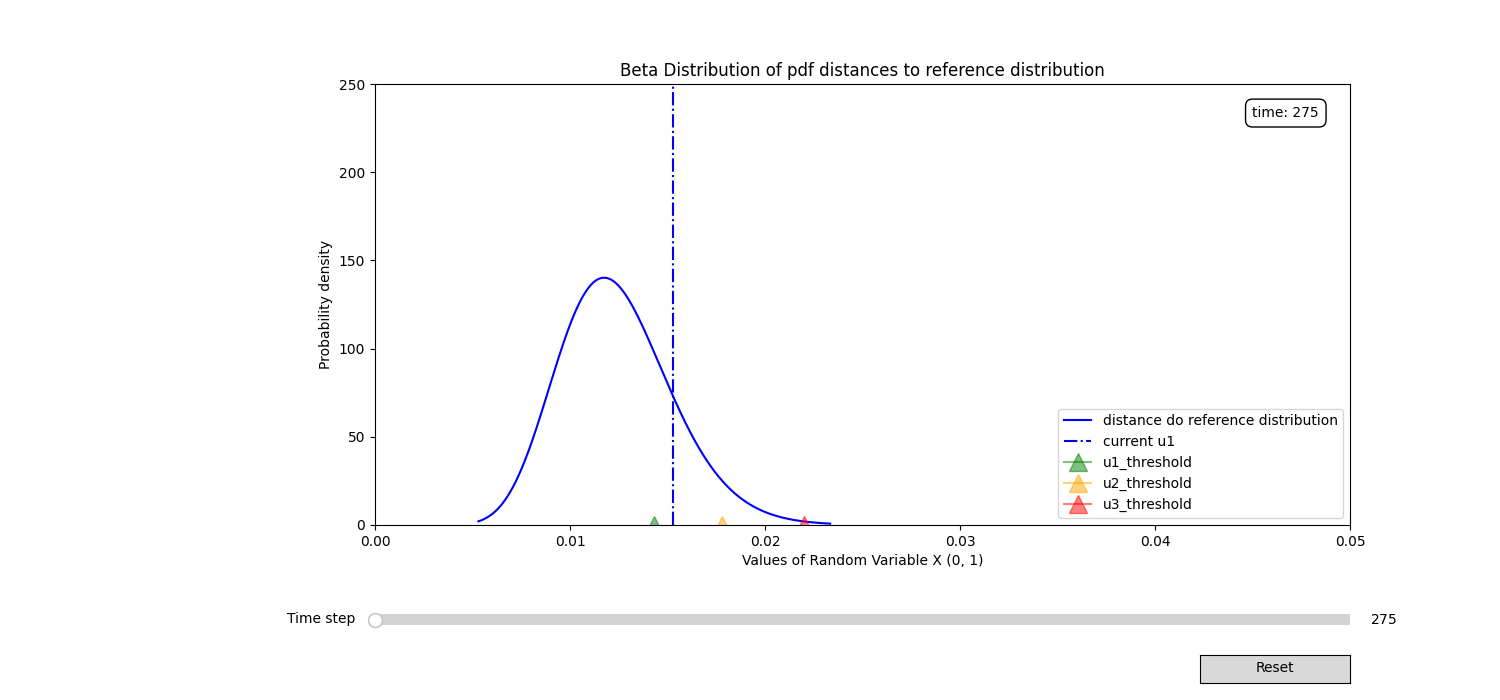

In [19]:
plot_slider_animation(alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list, first_frame=275, last_frame=350, y_max=250, x_max=0.05)

In [ ]:
change_detector = PDFChangeDetector(reference_size=30)

detection_status_list = []
alpha_estimates_list = []
beta_estimates_list = []
u1_min_list = []
u2_min_list = []
u3_min_list = []
current_u1_list = []

for i in range(500):
    new_pdf = gaussian_histogram(2, 1, 1000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")


for i in range(50):
    new_pdf = gaussian_histogram(2, 1.2, 1000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")

In [ ]:
data = pd.DataFrame([detection_status_list, alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list]).T

In [ ]:
data

In [ ]:
plot_slider_animation(alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list, first_frame=0, last_frame=549)